In [2]:
!pip install vizdoom

In [ ]:
!cd github & git clone https://github.com/mwydmuch/ViZDoom

In [7]:
# Import vizdoom for game env
from vizdoom import * 
# Import random for action sampling
import random
# Import time for sleeping
import time 
# Import numpy for identity matrix
import numpy as np

In [4]:
# Setup game
game = DoomGame()
# game.load_config('VizDoom/scenarios/basic.cfg')
game.load_config('VizDoom/scenarios/defend_the_center.cfg')
game.init()

In [5]:
# This is the set of actions we can take in the environment
actions = np.identity(3, dtype=np.uint8)

In [185]:
state = game.get_state()

In [186]:
state.game_variables

array([50.])

In [187]:
# Loop through episodes 
episodes = 10 
for episode in range(episodes): 
    # Create a new episode or game 
    game.new_episode()
    # Check the game isn't done 
    while not game.is_episode_finished(): 
        # Get the game state 
        state = game.get_state()
        # Get the game image 
        img = state.screen_buffer
        # Get the game variables - ammo
        info = state.game_variables
        # Take an action
        reward = game.make_action(random.choice(actions),4)
        # Print rewward 
        print('reward:', reward) 
        time.sleep(0.02)
    print('Result:', game.get_total_reward())
    time.sleep(2)

In [59]:
game.close()

In [8]:
!pip install gymnasium
!pip install opencv-python

In [8]:
# Import environment base class from OpenAI Gym
import gymnasium as gym
from gymnasium import Env
# Import gym spaces 
from gymnasium.spaces import Discrete, Box
# Import opencv 
import cv2

In [10]:
game.get_state().screen_buffer.shape

(3, 240, 320)

In [9]:
# Create Vizdoom OpenAI Gym Environment
class VizDoomGym(Env): 
    # Function that is called when we start the env
    def __init__(self, render=False): 
        # Inherit from Env
        super().__init__()
        # Setup the game 
        self.game = DoomGame()
        # self.game.load_config('VizDoom/scenarios/basic.cfg')
        self.game.load_config('VizDoom/scenarios/defend_the_center.cfg')
        self.seed_value = None
        
        # Render frame logic
        if render == False: 
            self.game.set_window_visible(False)
        else:
            self.game.set_window_visible(True)
        
        # Start the game 
        self.game.init()
        
        # Create the action space and observation space
        self.observation_space = Box(low=0, high=255, shape=(100,160,1), dtype=np.uint8) 
        self.action_space = Discrete(3)
        self.timestep = 0
        
    # This is how we take a step in the environment
    def step(self, action):
        # Specify action and take step 
        actions = np.identity(3)
        reward = self.game.make_action(actions[action], 4) 
        
        # Get all the other stuff we need to retun 
        if self.game.get_state(): 
            state = self.game.get_state().screen_buffer
            state = self.grayscale(state)
            ammo = self.game.get_state().game_variables[0]
            info = ammo
        else: 
            state = np.zeros(self.observation_space.shape)
            info = 0 
        self.timestep += 1
        info = {"info":info}
        done = self.game.is_episode_finished()

        truncated = self.timestep >= 2100
        # print(truncated)
        
        return state, reward, done, truncated, info 
    
    # Define how to render the game or environment 
    def render():
        pass
    """
    def seed(self, seed=None):
        self.seed_value = seed
        np.random.seed(seed)
    """
    # What happens when we start a new game 
    def reset(self, seed=42):
        # self.seed(seed)
        self.game.new_episode()
        self.timestep = 0
        state = self.game.get_state().screen_buffer
        info = {}
        return self.grayscale(state), info
    
    # Grayscale the game frame and resize it 
    def grayscale(self, observation):
        gray = cv2.cvtColor(np.moveaxis(observation, 0, -1), cv2.COLOR_BGR2GRAY)
        resize = cv2.resize(gray, (160,100), interpolation=cv2.INTER_CUBIC)
        state = np.reshape(resize, (100,160,1))
        return state
    
    # Call to close down the game
    def close(self): 
        self.game.close()

In [6]:
env = VizDoomGym(render=True)

In [7]:
state = env.reset()

In [8]:
env.close()

In [67]:
# %conda install conda-forge::stable-baselines3
# !pip install stable_baselines3[extra]

# !pip install git+https://github.com/DLR-RM/stable-baselines3

In [68]:
# %conda install pytorch torchvision torchaudio cpuonly -c pytorch
# !pip3 install torch torchvision torchaudio

In [5]:
# Import Environment checker
import stable_baselines3.common.env_checker 

In [7]:
stable_baselines3.common.env_checker.check_env(env)

In [9]:
from matplotlib import pyplot as plt

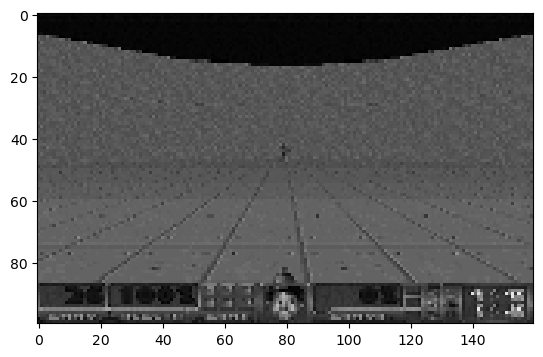

In [10]:
plt.imshow(cv2.cvtColor(state[0], cv2.COLOR_BGR2RGB))

In [11]:
# Import os for file nav
import os 
# Import callback class from sb3
from stable_baselines3.common.callbacks import BaseCallback

In [12]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [13]:
# CHECKPOINT_DIR = './train/train_basic'
# LOG_DIR = './logs/log_basic'
CHECKPOINT_DIR = './train/train_defend_the_center'
LOG_DIR = './logs/log_defend_the_center'

In [14]:
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

In [4]:
# import ppo for training
from stable_baselines3 import PPO, A2C

In [32]:
# Non rendered environment
env = VizDoomGym()

In [ ]:
# model = PPO('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, learning_rate=0.0001, n_steps=4096)
model = A2C('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, learning_rate=0.0007, n_steps=7)

In [35]:
model.learn(total_timesteps=100000, callback=callback)

Logging to ./logs/log_defend_the_center\A2C_23
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 76.6     |
|    ep_rew_mean        | -0.111   |
| time/                 |          |
|    fps                | 19       |
|    iterations         | 100      |
|    time_elapsed       | 35       |
|    total_timesteps    | 700      |
| train/                |          |
|    entropy_loss       | -1.1     |
|    explained_variance | -0.00707 |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -0.684   |
|    value_loss         | 0.998    |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 76.4     |
|    ep_rew_mean        | 0.0556   |
| time/                 |          |
|    fps                | 19       |
|    iterations         | 200      |
|    time_elapsed       | 70       |
|    total_timesteps    | 14

In [15]:
# Import eval policy to test agent
from stable_baselines3.common.evaluation import evaluate_policy

In [5]:
# Reload model from disc
# model = PPO.load('./train/train_basic/best_model_60000')
model = A2C.load('./train/train_defend_the_center/best_model_120000')

In [19]:
# Create rendered environment
env = VizDoomGym(render=True)

In [16]:
# Evaluate mean reward for 10 games
mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=10)

c:\Users\amrut\.conda\envs\doomscroll\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


In [18]:
mean_reward

12.9

In [20]:
for episode in range(5): 
    obs = env.reset()[0]
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, done, truncated, info = env.step(action)
        # time.sleep(0.20)
        # print(reward)
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward))
    time.sleep(2)

Total Reward for episode 0 is 14.0
Total Reward for episode 1 is 12.0
Total Reward for episode 2 is 4.0
Total Reward for episode 3 is 12.0
Total Reward for episode 4 is 15.0


In [21]:
env.close()